# Analysis of the Coronavirus by Coninent
Sam Schoberg and Liam Horch

## Introduction
The novel coronavirus is a disease that started in Asia in early 2020. At the time of writing this, the 69.1M people have been infected on all contients excluding Antarctica.

While each contient has dealt with infections and community spread, some regions have been able to better contain the virus. The goal of this tutorial is to discover how Coronavirus metrics (total confirmed cases, deaths, and total recovered) vary by contient.

This tutorial will have two exploratory sections including a map based approach and a grahpical approach. The graphical approach will then lead into hypothesis testing and ML analysis. 

In [41]:
# Necessary libraries and imports to complete this tutorial
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
!pip install countryinfo
from countryinfo import CountryInfo

You should consider upgrading via the '/Users/stschoberg/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


## Data Collection

We're collecting our dataset from the "COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University." They provide timeseries data for each metric (confirmed cases, deaths, recoveries) across all countries from 1/22/20 until current day. Its important to note that the dataset provides Province/State values for some countries. For example, the dataset provides values for all states within the United States while Afganistan only has country level metrics. Later, we'll have to deal with aggregating these values from states and countries to continents.

The URLs below start a .csv download of the timeseries data from Github. We then read the .csv into pandas dataframes. 

In [42]:
# Data urls
base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
confirmed_cases_data_url = base_url + 'time_series_covid19_confirmed_global.csv'
death_cases_data_url = base_url + 'time_series_covid19_deaths_global.csv'
recovery_cases_data_url = base_url+ 'time_series_covid19_recovered_global.csv'

# Import datasets as pandas dataframes
raw_data_confirmed = pd.read_csv(confirmed_cases_data_url)
raw_data_deaths = pd.read_csv(death_cases_data_url)
raw_data_recovered = pd.read_csv(recovery_cases_data_url)

raw_data_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,48116,48229,48527,48718,48952,49161,49378,49621,49681,49817
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,46863,47742,48530,49191,50000,50637,51424,52004,52542,53003
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,91121,91638,92102,92597,93065,93507,93933,94371,94781,95203
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,7236,7288,7338,7382,7382,7446,7466,7519,7560,7577
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,16061,16161,16188,16277,16362,16407,16484,16562,16626,16644


# Geographical Visualizations

First, we'll explore the data using a heatmap to try to build inutition about which contients and regions have been able to best contain the Coronavirus. Right off the bat, the first problem arises, we have messy data! Not to fear, for I specialize in cleaning up data. We shall simply drop the uneeded Province/State and Country/Region columns and then remove all nan values from our dataframe. Some may say that the formatting of the dates being column labels is an odd choice and while I agree, I find this layout easier to itterate over, so shall keep it as is.


In [43]:
raw_data_confirmed = pd.read_csv(confirmed_cases_data_url)

new_data = raw_data_confirmed.drop("Province/State", axis=1)
new_data  = new_data.drop("Country/Region", axis=1)

new_data = new_data.dropna()

  
new_data.head(10)

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20
0,33.93911,67.709953,0,0,0,0,0,0,0,0,...,48116,48229,48527,48718,48952,49161,49378,49621,49681,49817
1,41.15330,20.168300,0,0,0,0,0,0,0,0,...,46863,47742,48530,49191,50000,50637,51424,52004,52542,53003
2,28.03390,1.659600,0,0,0,0,0,0,0,0,...,91121,91638,92102,92597,93065,93507,93933,94371,94781,95203
3,42.50630,1.521800,0,0,0,0,0,0,0,0,...,7236,7288,7338,7382,7382,7446,7466,7519,7560,7577
4,-11.20270,17.873900,0,0,0,0,0,0,0,0,...,16061,16161,16188,16277,16362,16407,16484,16562,16626,16644
5,17.06080,-61.796400,0,0,0,0,0,0,0,0,...,147,148,148,148,148,151,151,152,152,153
6,-38.41610,-63.616700,0,0,0,0,0,0,0,0,...,1489328,1494602,1498160,1503222,1510203,1517046,1524372,1531374,1537169,1541285
7,40.06910,45.038200,0,0,0,0,0,0,0,0,...,146317,147312,148325,148682,149120,150218,151392,152253,153173,153825
8,-35.47350,149.012400,0,0,0,0,0,0,0,0,...,117,117,117,117,117,117,117,117,117,118
9,-33.86880,151.209300,0,0,0,0,3,4,4,4,...,4639,4642,4645,4650,4657,4666,4682,4712,4748,4771


We now must prep the data to be represented in the form of a heat map. A heat map takes in a list of lists, with each of those inner lists following the format of [lon, lat, weight], weight being the amount of confirmed cases for us. We shall proceed to itterate through our entire dataframe, adding these lists of longitude, latitude, and confirmed cases to an even larger list. We end up splitting this list into 2 so we may create a heat map for the first and second halves of the outbreak.

In [44]:
new_data['1/22/20'] = new_data['1/22/20']
all_data = new_data[['Lat', 'Long', '1/22/20']].to_numpy()
for column in new_data:
  if(column == '1/22/20' or column == 'new_col'):
    continue
  new_data[column] = new_data[column]
  heat_data = new_data[['Lat', 'Long', column]].to_numpy()
  heat_data = np.nan_to_num(heat_data)
  all_data = np.append(all_data, heat_data, axis=0)

all_data = np.nan_to_num(all_data)
split = math.ceil(len(all_data)/2)

first_half = all_data[:split]
second_half = all_data[split:]

Here is the heatmap representing the first half of the outbreak. Parameters for the heat map were decided through playing around, landing at these values for they represent the data the best.

In [45]:
from folium import plugins

m1 = folium.Map()
plugins.HeatMap(first_half, radius = 10, min_opacity = 0.1,gradient={.6: 'blue', .9: 'lime', .98: 'red'}).add_to(m1)
m1

And here is the heatmap for the second half of the outbreak.

In [46]:
m2 = folium.Map()
plugins.HeatMap(second_half, radius = 10, min_opacity = 0.1, gradient={.6: 'blue', .9: 'lime', .98: 'red'}).add_to(m2)
m2

The heatmaps display a strong concetration in Asia during the first half of the outbreak, as expected since it originated there, with a modest spread across the resrt of the world. The second half reveals an almost uniform severe concentration across all continents. As Covid consumes our meesly little heat map, all we can do is pray and watch.

# Graph Section Below

Now we'll use the intuition built from the heatmap to explore trends graphically. We'll start fresh with the raw dataframes.

In [47]:
raw_data_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,48116,48229,48527,48718,48952,49161,49378,49621,49681,49817
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,46863,47742,48530,49191,50000,50637,51424,52004,52542,53003
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,91121,91638,92102,92597,93065,93507,93933,94371,94781,95203
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,7236,7288,7338,7382,7382,7446,7466,7519,7560,7577
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,16061,16161,16188,16277,16362,16407,16484,16562,16626,16644


First, we'll drop the Latitude, Longitude, and Province/State columns from the raw dataframes. We're only interested in values at the contient level, so these columns aren't useful to us. Yes, Countries/Regions with multiple Province/State values will all have the same Country/Region value. For example, now there will be 50 rows with Country/Region as United States. This is okay because we'll aggregate these rows later. 

In [48]:
confirmed_by_country = raw_data_confirmed.drop(columns=['Lat', 'Long', 'Province/State'])
deaths_by_country = raw_data_deaths.drop(columns=['Lat', 'Long', 'Province/State'])
recovered_by_country = raw_data_recovered.drop(columns=['Lat', 'Long', 'Province/State'])
recovered_by_country.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,38141,38200,38250,38252,38336,38475,38505,38540,38613,39006
1,Albania,0,0,0,0,0,0,0,0,0,...,24136,24520,24820,24820,25876,26381,26898,27426,27831,28121
2,Algeria,0,0,0,0,0,0,0,0,0,...,59590,60028,60457,60888,61307,61700,62089,62487,62869,63260
3,Andorra,0,0,0,0,0,0,0,0,0,...,6598,6629,6629,6706,6706,6819,6875,6919,6963,6997
4,Angola,0,0,0,0,0,0,0,0,0,...,8798,8841,8898,8924,8990,9194,9266,9345,9518,9592


Next, we'll transpose the dataframe so the Country/Region names are the columns and the date strings are the rows. Setting the index to Country/Region before transposing ensures the Country/Region will be the column names in the transposed dataframe. We transposed the dataframe because it'll be easier to plot using our imported libraries. 

In [49]:
# Transpose so country is columns and date strings are rows
confirmed_by_country = confirmed_by_country.set_index('Country/Region').T
deaths_by_country = deaths_by_country.set_index('Country/Region').T
recovered_by_country = recovered_by_country.set_index('Country/Region').T
recovered_by_country.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Australia,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we have to account for a subtle detail. The index values of all the rows look like dates, but they're in fact strings. We'll have to convert these strings to datetime objects if we want to plot our metrics over time using a line chart. Since all three dataframes have matching row indicies, we only convert the indicies of confirmed_by_country to a datetime then apply that to all three dataframes. 

In [50]:
dt_series = pd.to_datetime(confirmed_by_country.index)
datetime_index = pd.DatetimeIndex(dt_series.values)

confirmed_by_country_dt=confirmed_by_country.set_index(datetime_index)
deaths_by_country_dt=deaths_by_country.set_index(datetime_index)
recovered_by_country_dt=recovered_by_country.set_index(datetime_index)

Before we can plot the confirmed, death, and recovered metrics for each continent, we need to consider more information about each country.

1. We need to be able to map each country to its respective continent.
2. We need to know the population of each country. This is important to be able to compare values between countries. For example, the USA may have 250,000 new daily cases while Moldova has 1,700. It doesn't do much good to compare these two values becuase the USA has 330M residents while has 3.5M residents. Of course the US is going to have more daily cases! We need the population of each country to standardize the values in the dataframe by population (we using per/ 100,000 residents).

To obtain this data we're using the python package CountryInfo. Its important to note that some countries listed in the dataframe do not have information in the CountryInfo package. We dropped these countries from our dataset. We don't believe this will impact our analysis because they are only small nations with few cases. 

In [51]:
pop_dict = {}
region_dict = {}
unlisted_countries = []

for country in raw_data_confirmed['Country/Region']:
  try:
    info = CountryInfo(country).info()
    pop = info['population']
    pop_dict[country] = pop
    region_dict[country] = info['region']
  except:
    unlisted_countries.append(country)

print("UNLISTED COUNTRIES: ", unlisted_countries)
confirmed_by_country_dt.drop(columns=unlisted_countries, inplace=True)
deaths_by_country_dt.drop(columns=unlisted_countries, inplace=True)
recovered_by_country_dt.drop(columns=unlisted_countries, inplace=True)

UNLISTED COUNTRIES:  ['Andorra', 'Bahamas', 'Burma', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Czechia', 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Korea, South', 'Kosovo', 'MS Zaandam', 'Montenegro', 'North Macedonia', 'Sao Tome and Principe', 'Taiwan*', 'Timor-Leste', 'West Bank and Gaza']


Now that we have population data for each country and each country's continent, we calculate the population of each continent and standardize it by 100,000 residents.

In [52]:
continent_populations = {continent: 0 for country, continent in region_dict.items()}
for country, pop in pop_dict.items():
  continent_populations[region_dict[country]]+=pop

continent_populations_standardized = {continent: pop/100000 for continent, pop in continent_populations.items()}

Next, we'll map each country to a continent in our dataframes using the data from the CountryInfo package. 

In [53]:
# Assign each country column to a region 
confirmed_by_region = confirmed_by_country_dt.rename(columns=region_dict)
deaths_by_region = deaths_by_country_dt.rename(columns=region_dict)
recovered_by_region = recovered_by_country_dt.rename(columns=region_dict)

Now we'll consider contients that are listed multiple times. It makes sense that there are many columns labeled with the same contient because there are many counties in a contients. 

In [54]:
recovered_by_region.tail()

Country/Region,Asia,Europe,Africa,Africa,Americas,Americas,Asia,Oceania,Oceania,Oceania,...,Europe,Europe,Americas,Asia,Oceania,Americas,Asia,Asia,Africa,Africa
2020-12-16,38475,26381,61700,9194,141,1347914,128694,114,3192,59,...,741,0,7142,72810,1,103492,1252,1384,17635,9702
2020-12-17,38505,26898,62089,9266,141,1352556,129990,114,3192,59,...,741,0,7406,72810,1,103741,1263,1384,17680,9836
2020-12-18,38540,27426,62487,9345,141,1356755,131213,114,3192,59,...,741,0,7699,72961,1,103975,1266,1384,17729,9894
2020-12-19,38613,27831,62869,9518,141,1362617,131931,114,3192,59,...,755,0,8002,73099,1,104208,1269,1384,17756,9984
2020-12-20,39006,28121,63260,9592,143,1368346,132532,114,3192,59,...,759,0,8327,73242,1,104462,1269,1384,17762,10024


We'll sum all columns with the same country name and standardize their values based on the contient populations calculated earlier.

In [55]:
confirmed_by_region=confirmed_by_region.groupby(confirmed_by_region.columns, axis=1).sum()
deaths_by_region=deaths_by_region.groupby(deaths_by_region.columns, axis=1).sum()
recovered_by_region=recovered_by_region.groupby(recovered_by_region.columns, axis=1).sum()

confirmed_by_region_standardized = pd.DataFrame()
deaths_by_region_standardized = pd.DataFrame()
recovered_by_region_standardized = pd.DataFrame()

for cont in confirmed_by_region.columns:
  confirmed_by_region_standardized[cont]=confirmed_by_region[cont].apply(lambda val: val / continent_populations_standardized[cont])
  deaths_by_region_standardized[cont]=deaths_by_region[cont].apply(lambda val: val / continent_populations_standardized[cont])
  recovered_by_region_standardized[cont]=recovered_by_region[cont].apply(lambda val: val / continent_populations_standardized[cont])

Finally, we'll plot the deaths, confirmed cases, and recoveries for all contients.

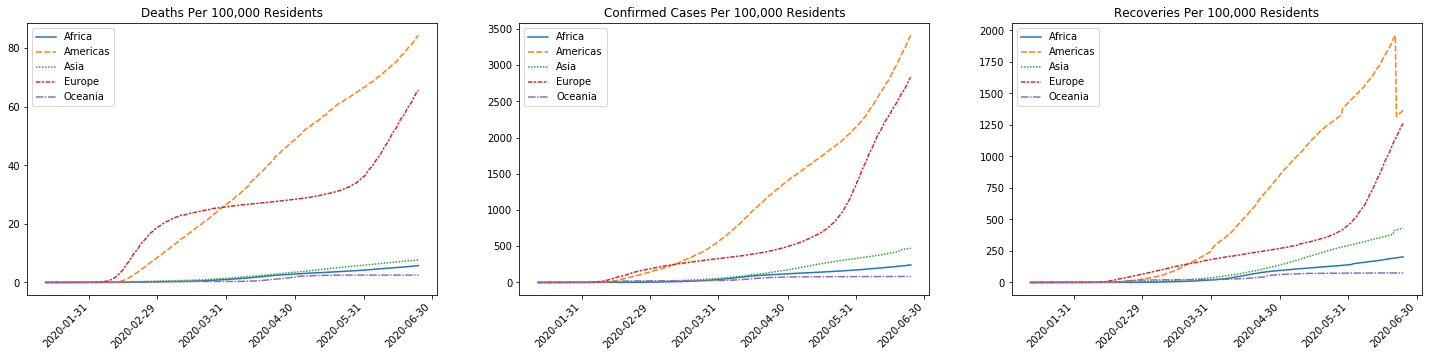

In [56]:
fig, axs = plt.subplots(ncols=3,figsize=(25,5))

axs[0].set_title("Deaths Per 100,000 Residents")
axs[1].set_title("Confirmed Cases Per 100,000 Residents")
axs[2].set_title("Recoveries Per 100,000 Residents")

# Gets end of every month to set as x ticks
month_dates = deaths_by_region.resample('M').sum().index.strftime('%Y-%m-%d')

axs[0].set_xticklabels(labels=month_dates, rotation=45, ha='right')
axs[1].set_xticklabels(labels=month_dates, rotation=45, ha='right')
axs[2].set_xticklabels(labels=month_dates, rotation=45, ha='right')

sns.lineplot(data=deaths_by_region_standardized, ax=axs[0])
sns.lineplot(data=confirmed_by_region_standardized, ax=axs[1])
sns.lineplot(data=recovered_by_region_standardized, ax=axs[2])

## Analysis

Its clear that not all continents were able to contain the Coronavirus equally. For example, Asia, Europe, and Oceania have been able to maintain relatively low death tolls and confirmed cases. All three have stayed below 500 confirmed cases and below 10 deaths per 100,000 citizens.

On the other hand, the Americas and Europe have had a much more difficult time stopping the virus's spread. Cases and deaths have risen consistently in the Americas since March of 2020. Europe seemed to contain the virus from April 2020 to October 2020 after an initial outbreak in March, but has since lost control.

Its clear that Oceania, Asia, and Africa have the closest values for death totals. We want to see if the mean increase in deaths per day is the same for each of those continents. We'll perform a paired t-test on the increase in deaths per 100,000 people for each Continent in the last 30 days.

Upon calculating the increase in deaths per day, it becomes clear that Oceania has nearly contained the virus. In the last 30 days, they have 0 new COVID deaths each day (good for oceania!). Becuase of this, we'll only perform the paired t-test betweeen Africa and Asia.

**Null hypothesis:** The true mean difference between increase in deaths of Africa and Asia in the last 30 days is 0. 

In [57]:
inc_deaths_last_30=deaths_by_region_standardized[['Africa', 'Asia', 'Oceania']].iloc[-30:-1].diff()
inc_deaths_last_30.describe()

,Africa,Asia,Oceania
count,28.000000,28.000000,28.000000
mean,0.032775,0.037157,0.000190
std,0.006861,0.003246,0.000698
min,0.022216,0.031598,0.000000
25%,0.027522,0.034349,0.000000
50%,0.031836,0.037848,0.000000
75%,0.039002,0.039583,0.000000
max,0.049093,0.043034,0.002660


In [58]:
stats.ttest_rel(inc_deaths_last_30[['Africa']][1:],inc_deaths_last_30[['Asia']][1:]  )

Ttest_relResult(statistic=array([-2.60565399]), pvalue=array([0.01473902]))

Since the pvalue is 0.01473902, we reject the null hypothesis that the mean difference between increase of deaths in Africa and Asia in the last 30 days is 0. We can say with 95% certainty that Asia has had a greater average increase in deaths in the last 30 days. 

## Modeling the Future

From the Deaths graph above, it appears that the number of deaths in the Americas increases linearlly with time after 3-31-2020. In order to predict the number of deaths the Americas might see in the future, we'll fit a linear model to this data.

To see if a linear model fits the data well, we'll calculate an R^2 value which will tell us how much the increase in total deaths is influenced by the progression of time. 

Its important to note that our linear model and R^2 calculation don't accept Datetimes as paramenters. We have to convert the datetimes to some scalar value. To do this, we'll encode the datetimes as the number of days since 3-31-2020. This retains all the relevant information and converts the data into a format ingestible by sklearn.



In [59]:
deaths_americas=deaths_by_region_standardized['Americas'].iloc[69:]
days_since_3312020 = (deaths_americas.index -  deaths_americas.index[0]).days.values.reshape(-1, 1)

reg = LinearRegression().fit(days_since_3312020, deaths_americas.values)
r2_score(reg.predict(days_since_3312020), deaths_americas.values)

0.9983417150718068

The linear model recieves an R^2 score of 0.998. This means that the model explains 99% of the increase in total deaths in the Americas starting at 3-30-2020 and ending at current day. We'll confirm the accuracy of our model by plotting it against the true values.







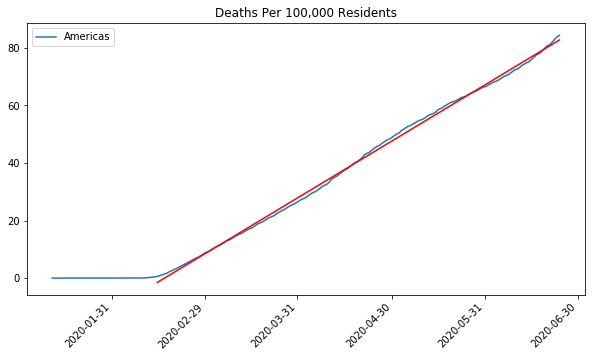

In [60]:
fig, axs = plt.subplots(figsize=(10,5))
axs.set_title("Deaths Per 100,000 Residents")

# Gets end of every month to set as x ticks
month_dates = deaths_by_region.resample('M').sum().index.strftime('%Y-%m-%d')
axs.set_xticklabels(labels=month_dates, rotation=45, ha='right')

sns.lineplot(data=deaths_by_region_standardized[['Americas']], ax=axs)
sns.lineplot(deaths_by_region_standardized['Americas'].iloc[69:].index, reg.predict(days_since_3312020).reshape(-1), color='red')

We'll now use the model to predict the total deaths in the upcoming weeks.

I am writing this section on Dec. 14, and The final deliverable is due on Dec. 21. We'll have our model predcit the total deaths in the Americas for that date. If you're interested, you can run the cell during grading and see how close our prediction was.

In [61]:
# reg.predict(deaths_americas.index[0])
import datetime

pred = reg.predict(np.array([(datetime.datetime(2020, 12, 21) - deaths_americas.index[0]).days]).reshape(-1, 1))
print("The total deaths per 100,000 citizens in the Americas is predicted to be: ", pred[0])

The total deaths per 100,000 citizens in the Americas is predicted to be:  83.09433628938142


## Conclusion and Insights

From our analysis of COVID metrics by continents, its clear that not everyone has been able to contain the virus effectively. Some regions, for example Africa and Asia, have consistently maintained low numbers of deaths and confirmed cases. Oceania has managed to curb community transmission with nearly 0 new confirmed cases in the last 30 days. The Americas and Europe, on the other hand, have been unable to contain the virus's spread. The total Americas deaths have been increasing linearally since March 2020. Cases in Europe plateaued between April and September 2020 but have since started increasing again.

Since we standardized all of our values for population, we can assume that there are certain policies or environmental factors in regions like Oceania and Africa that allowed them to control the virus. It isn't the job of the data analysts (or 320 students) to make medical recommendations, however we can say that it may be useful for Europe and the Americas to look ot the tactics in those better-performing regions for ideas on how to reduce community transmission of COVID-19. 